In [9]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt

In [10]:
args_infer = {
    "model_path" : "runs/bce_grasp_bottle_attn4.ckpt",
    "device" : "cuda",
    "img_size" : 1120
}

In [11]:
device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=args_infer["img_size"])
dataset = JacquardSamples(image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"])
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

In [41]:
test_idx =4
data = dataset[test_idx]
img = data["img"].to(device)
img = torch.permute(img, (0, 2, 1))
grasp = data["points_grasp"]//14
grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
grasp = torch.cat([grasp, grasp_inv], dim=0)
features, clk = model.forward_dino_features(img.unsqueeze(0))
attn = model.forward_dino_attentions(img.unsqueeze(0)).squeeze()[:,0,1:]
attn_norms = torch.norm(attn, dim=0).reshape(args_infer["img_size"]//14, args_infer["img_size"]//14)

features = features.squeeze().reshape(args_infer["img_size"]//14, args_infer["img_size"]//14, 384)

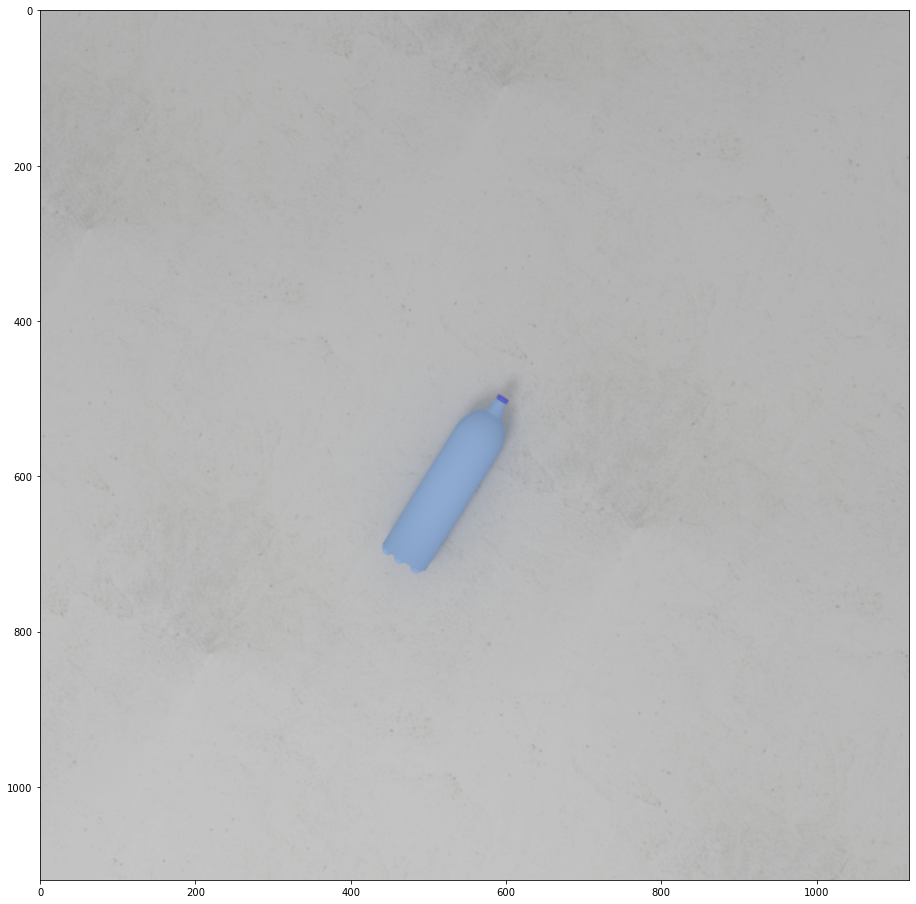

In [42]:
plt.figure(figsize=(16,16))
org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
plt.imshow(org_image)

# Test gt points certainty

In [43]:
all_points = grasp
mean_feats=[]
diffs = []
for i in range(all_points.shape[0]):
    imix = all_points[i,:,0].min()
    imax = all_points[i,:,0].max()
    ymix = all_points[i,:,1].min()
    ymax = all_points[i,:,1].max()
    dif = (all_points[i, 0, :] - all_points[i, 1, :]).type(torch.float32)
    if dif[0] == 0 and dif[1] == 0:
        dif = torch.zeros(4).to(device)
    else:
        dif = dif / dif.norm(p=2, dim=-1, keepdim=True)
        dif = torch.cat([dif, dif*-1])
    features_i = features[imix:imax+1, ymix:ymax+1, :]
    attn_i = attn_norms[imix:imax+1, ymix:ymax+1].mean()
    features_i = features_i.reshape(features_i.shape[0] * features_i.shape[1], features_i.shape[2]).mean(0)/attn_i
    #features_i = torch.cat([features_i, clk.squeeze()], dim=0)
    if i == 0:
        mean_feats = features_i.unsqueeze(0)
        diffs = dif.unsqueeze(0)
    else:
        mean_feats = torch.cat([mean_feats, features_i.unsqueeze(0)], dim=0)
        diffs = torch.cat([diffs, dif.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model(mean_feats.to(device), diffs.to(device))

In [44]:
print(preds.mean())

tensor(0., device='cuda:0')


# Test single point

In [ ]:
point_idx = 0

sx = 300
sy = 300
single_point = torch.tensor([sy//14, sx//14])
single_point = grasp[point_idx][0]
single_point = single_point.unsqueeze(0).repeat(args_infer["img_size"]//14*args_infer["img_size"]//14,1).unsqueeze(1)
all_points = torch.tensor([[i,j] for j in range(args_infer["img_size"]//14) for i in range(args_infer["img_size"]//14)]).unsqueeze(1)
all_points = torch.cat([single_point, all_points], dim=1).to(device)
mean_feats=[]
diffs = []
for i in range(all_points.shape[0]):
    imix = all_points[i,:,0].min()
    imax = all_points[i,:,0].max()
    ymix = all_points[i,:,1].min()
    ymax = all_points[i,:,1].max()
    dif = (all_points[i, 0, :] - all_points[i, 1, :]).type(torch.float32)
    if dif[0] == 0 and dif[1] == 0:
        dif = torch.zeros(4).to(device)
    else:
        dif = dif / dif.norm(p=2, dim=-1, keepdim=True)
        dif = torch.cat([dif, dif*-1])
    features_i = features[imix:imax+1, ymix:ymax+1, :]
    attn_i = attn_norms[imix:imax+1, ymix:ymax+1].mean()
    features_i = features_i.reshape(features_i.shape[0] * features_i.shape[1], features_i.shape[2]).mean(0)/attn_i
    if i == 0:
        mean_feats = features_i.unsqueeze(0)
        diffs = dif.unsqueeze(0)
    else:
        mean_feats = torch.cat([mean_feats, features_i.unsqueeze(0)], dim=0)
        diffs = torch.cat([diffs, dif.unsqueeze(0)], dim=0)
with torch.no_grad():
    preds = model(mean_feats.to(device), diffs.to(device))


In [ ]:
topk=3
if topk != 0:
    topk, ind = torch.topk(preds.squeeze(), topk)
    preds = torch.zeros(6400)
    preds[ind] = 1
preds = preds.squeeze().reshape(args_infer["img_size"]//14, args_infer["img_size"]//14).unsqueeze(0).unsqueeze(0)

preds = torch.nn.functional.interpolate(preds, (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
preds = torch.permute(preds, (1, 0))
print(preds.shape)

In [ ]:
zeros = torch.zeros(args_infer["img_size"], args_infer["img_size"], 1)
preds = torch.cat([preds.cpu().detach().unsqueeze(2), zeros, zeros], dim = 2)
origin_point = np.zeros((3, args_infer["img_size"]//14, args_infer["img_size"]//14))
origin_point[:, single_point[0][0][0], single_point[0][0][1]] = [0, 1, 0]
origin_point = torch.nn.functional.interpolate(torch.tensor(origin_point).unsqueeze(0), (args_infer["img_size"], args_infer["img_size"]), mode="nearest").squeeze()
origin_point = torch.permute(origin_point,(1, 2, 0)).cpu().detach().numpy()

plt.figure(figsize=(16,16))
show_img = org_image + 0.7*preds.cpu().detach().numpy() + 0.7*origin_point
#show_img = org_image + 0.7*origin_point2 + 0.7*origin_point
plt.imshow(show_img)